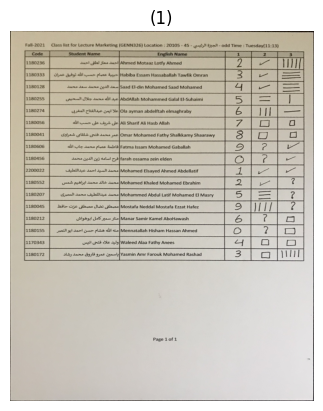

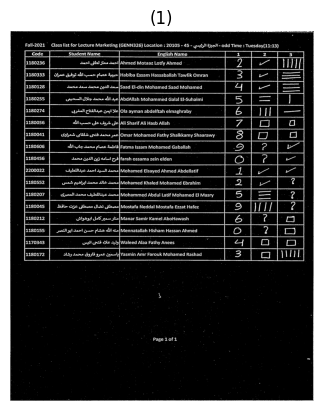

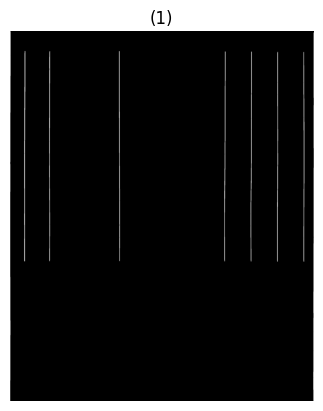

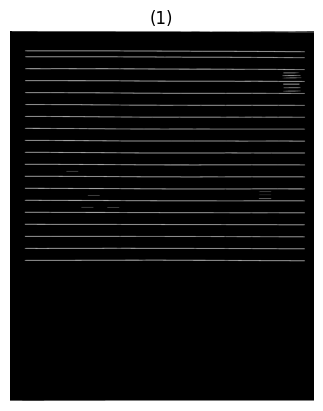

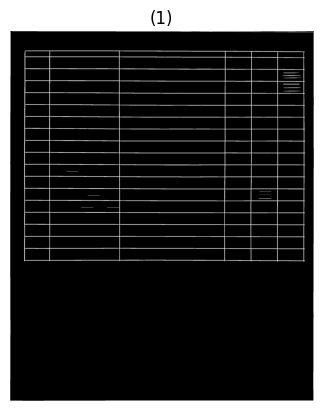

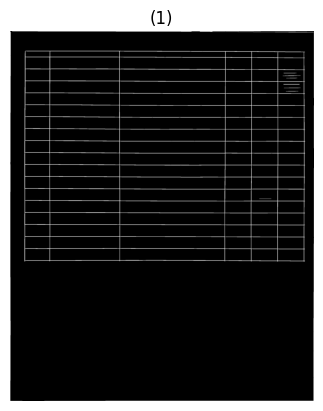

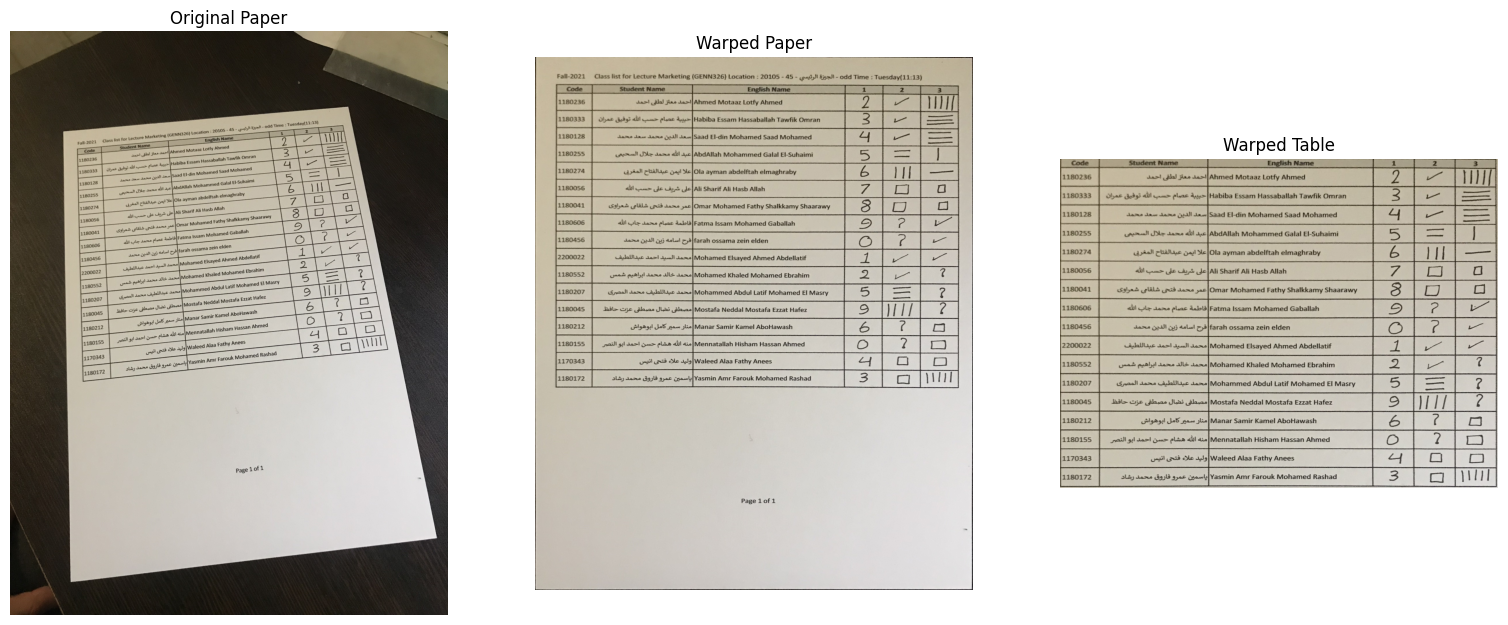

In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from utils import *
from paperExtraction import *

imagePath = "../data/images/7.jpg"
image = cv.imread(imagePath)
imageRGB = cv.cvtColor(image, cv.COLOR_BGR2RGB)

# Getting paper image
paperImage = extractPaper(imagePath)
show_images([paperImage])

# Convert to gray and threshold
paperGrayScale = cv.cvtColor(paperImage, cv.COLOR_RGB2GRAY)
gaussian = cv.GaussianBlur(paperGrayScale, (7,7), 0)
binary = cv.adaptiveThreshold(gaussian, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV, 15, 2)
show_images([binary])

# Morphology to extract table lines
verticalSE = cv.getStructuringElement(cv.MORPH_RECT, (1, 20))
verticalLines = cv.erode(binary, verticalSE, iterations = 5)
verticalLines = cv.dilate(verticalLines, verticalSE, iterations = 5)
show_images([verticalLines])

horizontalSE = cv.getStructuringElement(cv.MORPH_RECT, (20, 1))
horizontalLines = cv.erode(binary, horizontalSE, iterations = 5)
horizontalLines = cv.dilate(horizontalLines, horizontalSE, iterations = 5)
show_images([horizontalLines])

# Combine lines to get table mask
tableMask = cv.add(verticalLines, horizontalLines)
show_images([tableMask])

# Erosion needed to remove small lines
tableMask = cv.erode(tableMask, cv.getStructuringElement(cv.MORPH_RECT, (2,2)), iterations = 2)
tableMask = cv.dilate(tableMask, cv.getStructuringElement(cv.MORPH_RECT, (2,2)), iterations = 1)
show_images([tableMask])

# Find table contour
contours, _ = cv.findContours(tableMask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# Largest contour in table mask is table
table_contour = max(contours, key=cv.contourArea)

# Warp the table
# Experimenting other way to get ordered points and wrap height and width
rect = cv.minAreaRect(table_contour)
box = cv.boxPoints(rect)
box = np.array(box, dtype="float32")
s = box.sum(axis=1)
tl = box[np.argmin(s)]
br = box[np.argmax(s)]
diff = np.diff(box, axis=1)
tr = box[np.argmin(diff)]
bl = box[np.argmax(diff)]
ordered_box = np.array([tl, tr, br, bl], dtype="float32")

widthA = np.linalg.norm(br - bl)
widthB = np.linalg.norm(tr - tl)
maxWidth = int(max(widthA, widthB))
heightA = np.linalg.norm(tr - br)
heightB = np.linalg.norm(tl - bl)
maxHeight = int(max(heightA, heightB))

dst = np.array([[0,0], [maxWidth,0], [maxWidth,maxHeight], [0,maxHeight]], dtype = "float32")
M = cv.getPerspectiveTransform(ordered_box, dst)
table_image = cv.warpPerspective(paperImage, M, (maxWidth, maxHeight))
show_images([imageRGB, paperImage, table_image], titles=["Original Paper", "Warped Paper", "Warped Table"])
